Bay Wheels is a regional public bicycle sharing system in California's San Francisco Bay Area. This dataset is taken from the following website https://www.lyft.com/bikes/bay-wheels/system-data and represents trips taken by members of the service for the month of June of 2020.

The data is anonymized and and trips include:

- Start Time and Date
- End Time and Date
- Trip duration
- Rideable Type
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Ride ID
- User Type

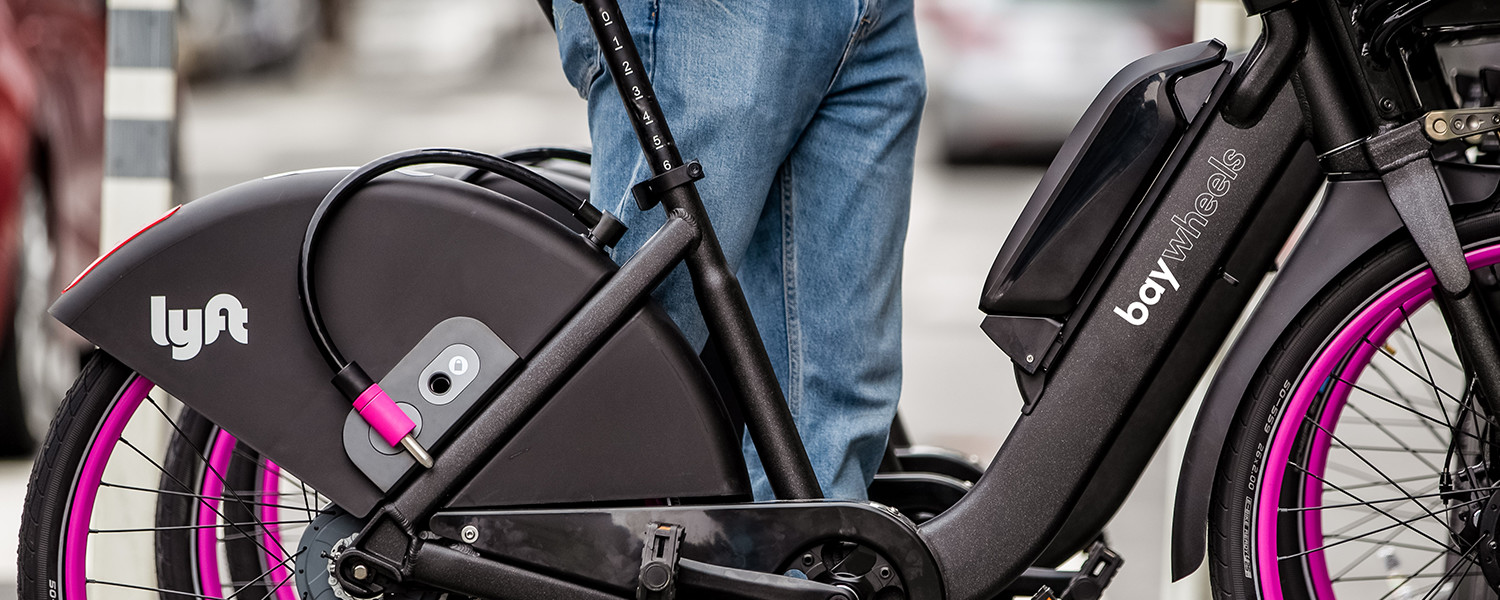

In [158]:
from IPython.display import Image
Image("vPrHTOga.jpg")

#### Upload the data 

In [1]:
import pandas as pd
df = pd.read_csv(r"baywheeljune2020.csv")

In [2]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
0,172957A20160D568,electric_bike,2020-06-03 15:16:06,2020-06-03 16:06:10,Church St at Duboce Ave,85.0,48th Ave at Cabrillo St,521.0,37.769841,-122.429210,37.772894,-122.509079,casual,3004.0
1,AC29BDD9051D1827,electric_bike,2020-06-03 12:13:30,2020-06-03 12:36:27,Cesar Chavez St at Dolores St,140.0,4th St at 16th St,104.0,37.747758,-122.425121,37.767008,-122.390851,casual,1377.0
2,7E0C4C5917A9EEC2,electric_bike,2020-06-02 19:18:23,2020-06-02 19:46:05,The Embarcadero at Vallejo St,8.0,Hyde St at Post St,369.0,37.799943,-122.398562,37.787527,-122.416830,casual,1662.0
3,6B0E4BF2BBD49A9D,electric_bike,2020-06-03 10:06:26,2020-06-03 10:38:15,Green St at Van Ness Ave,496.0,Green St at Van Ness Ave,496.0,37.797636,-122.423418,37.797653,-122.423335,casual,1909.0
4,27C607CB14528333,electric_bike,2020-06-03 13:09:05,2020-06-03 13:31:33,4th St at 16th St,104.0,Cesar Chavez St at Dolores St,140.0,37.767064,-122.390900,37.747827,-122.425056,casual,1348.0


In [3]:
df.shape

(79858, 14)

In [5]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'trip_duration'],
      dtype='object')

- How many rideable type are there in the dataset?

In [6]:
df["rideable_type"].unique()

array(['electric_bike', 'docked_bike'], dtype=object)

In [7]:
df["rideable_type"].nunique()

2

- Compute the speed using the following function.

In [8]:
from geopy.distance import geodesic #We import a function 'geodesic' from a module file 'distance' which belongs to 'geopy' package
# You just need to go to juptyper terminal and install geopy : conda install -c conda-forge geopy
def distance(row): 
    add1 = (row['start_lat'], row['start_lng']) 
    add2 = (row['end_lat'], row['end_lng']) 
    return (geodesic(add1, add2).km) 

df['distance'] = df.apply(lambda row: distance(row), axis = 1)*1.2 

In [9]:
df['speed']=df['distance']/(df['trip_duration']/3600)

### Statistical analysis

#### Compute the z-score  of speed 

In [10]:
# method 1
from scipy import stats
df['zscore']=stats.zscore(df['speed'])

- Use another method to compute the z-score

In [11]:
# method 2
df["zscore"] = ((df['speed']-df['speed'].mean())/df['speed'].std())

- How many outliers are there? Set threshold to 2.5

In [12]:
#count how many outliers
print(len(df[abs(df['zscore'])> 2.5]))

57


#### Compute the kurtosis and skewness

In [13]:
stats.kurtosis(df['speed'])

3813.534316976184

In [14]:
stats.skew(df['speed'])

32.03774309724288

#### Hypothesis Testing

In [15]:
df.groupby('rideable_type')['speed'].agg(['mean','std','count'])

,mean,std,count
rideable_type,,,
docked_bike,8.189214,7.65067,48677
electric_bike,12.221408,6.49118,31181


We want to compare the sample means for both docked and electric bikes. 
- Which test shall we perform to test whether the two means are significantly different? Student Test.
- Write a function which takes two sample groups and return the appropriate statistics of the test and its degree of freedom.

In [39]:
# t-test
import numpy as np

def test(x, y):
    nx, ny = x.size, y.size
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    
    df = ((vx/nx + vy/ny)**2 /
    ((vx/nx)**2 / (nx - 1) + (vy/ny)**2 / (ny - 1)))
    
    t_obs = (x.mean() - y.mean()) / np.sqrt(vx/nx + vy/ny)
    return print('t-test: ',t_obs, '   Degree of Freedom Value: ', df)

In [40]:
x = df[df['rideable_type'] == 'docked_bike']['speed']
y = df[df['rideable_type'] == 'electric_bike']['speed']

test(x,y)

t-test:  -79.79007139816225    Degree of Freedom Value:  73884.77125857078


* Are the two means statistically different from each other with a significance level of 5%? t_0.05 = 1.96


|t-test| > t_0.05 : We reject the null hypothesis (H0: the means are equal) =>  The means are statistically different from each other.

In [41]:
from scipy.stats import ttest_ind  

print ('Statistics=%.3f, p=%.3f' % (stats.ttest_ind(x, y, equal_var=False)))

Statistics=-79.790, p=0.000


### Clustering methods

#### K-means

Pseucode algorithm :
1. Select K as the initial centroids
2. Repeat:
3.  $\;\;\;\;$ Form K clusters by assigning all points to the closest centroids
4.  $\;\;\;\;$ Recompute the centroid for each cluster
5.  Until centroid stop changing

In [18]:
X= df[df['start_station_name']=='Church St at Duboce Ave'] ## We select a specific station

In [19]:
#Scale data

from sklearn.cluster import KMeans
from sklearn import preprocessing
Z = preprocessing.scale(X[['speed','trip_duration','distance']])

- Why do we use scaling before clustering? 

Features might have different units and scale. Some distance measures used in clustering (like Euclidian distance) can be affected by a such difference. Thus scaling ensure that all variables are treated equally and avoid bad clustering.

In [20]:
score = []
for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster)
    preds= kmeans.fit(Z)
    score.append(kmeans.inertia_) 

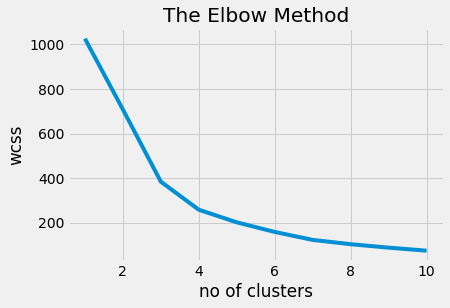

In [21]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

- What is the purpose of using the Elbow method? What does WCSS refers to? How do we interpret the result? 

- Elbow method is used to determine the number of clusters in a dataset. 
- The Within-Cluster-Sum-of-Squares (WCSS) aka inertia is the sum of squares of the distances of each data point in all clusters to their respective centroids.
- By ploting the number of clusters and the WCSS, we notice a rapid change of the value of wcss from 2 to 3, which creates an elbow shape. Thus, 3 is number of cluster determined by the Elbow method.


The silhouette analysis measures how well the data points are clustered by estimating
the average distance between clusters. The silhouette plot tells about how close each
point in one cluster is to points in the neighboring clusters.

In [22]:
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Z)
    score = silhouette_score(Z, kmeans.labels_)
    silhouette_coefficients.append(score)

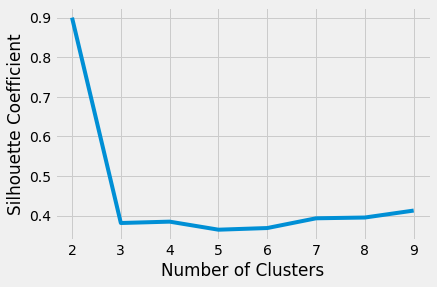

In [23]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

- Perform k-means on the best number of cluster.

In [24]:
kmeans = KMeans(n_clusters=2) #We select the number of cluster that has the higher silhouette index
kmeans.fit(Z)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- We plot the speed and the distance of the trips, with the assigned clusters. Interpret the latter by projecting also on other variables. 

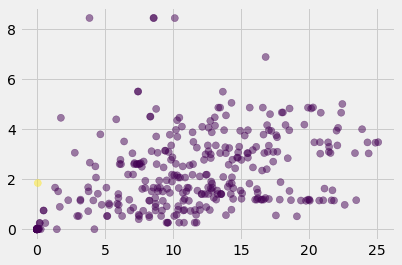

In [25]:
y_kmeans = kmeans.predict(Z) #Assign clusters to observations
plt.scatter(X['speed'], X['distance'], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)

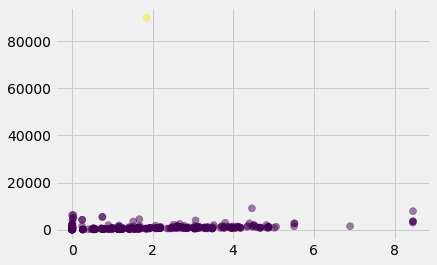

In [26]:
y_kmeans = kmeans.predict(Z) #Assign clusters to observations
plt.scatter(X['distance'], X['trip_duration'], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)

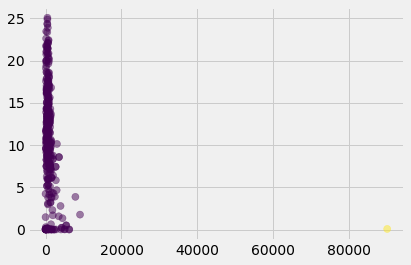

In [27]:
y_kmeans = kmeans.predict(Z) #Assign clusters to observations
plt.scatter(X['trip_duration'], X['speed'], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)

We notice that k-means is detecting an outlier (yellow), which has a much longer trip duration than the other observations.

#### Agglomerative Hierarchical clustering

The initialization of this algorithm consists to calculate an array of distances (or
dissimilarities) between the data points to be classified. The algorithm starts from the
trivial partition of the N singletons (each observation represents a cluster) and seeks, at
each step, to form clusters by aggregating the two closest data points to the stage partition former. The algorithm stops by obtaining a single class. The successive groupings
are represented in the form of a dendrogram.

In [28]:
from sklearn.cluster import AgglomerativeClustering
silhouette_coefficients = []
# silhouette coefficient
for k in range(2, 10):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
    model = model.fit(Z)
    score = silhouette_score(Z, model.labels_)
    silhouette_coefficients.append(score)

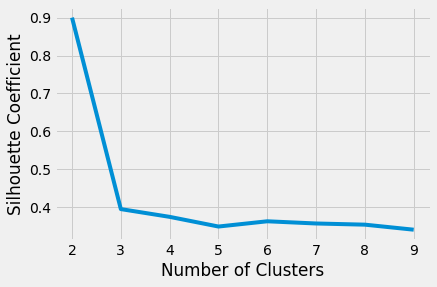

In [29]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

- Perform an HC based on the convenient number and interpret the clusters. 

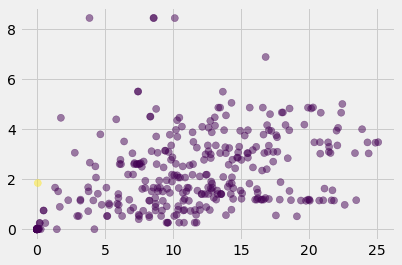

In [34]:
model = AgglomerativeClustering(n_clusters=2)  #We select the number of cluster that has the highest silhouette index
model = model.fit(Z)
plt.scatter(X['speed'], X['distance'], c=model.labels_, s=50, cmap='viridis', alpha=0.5)

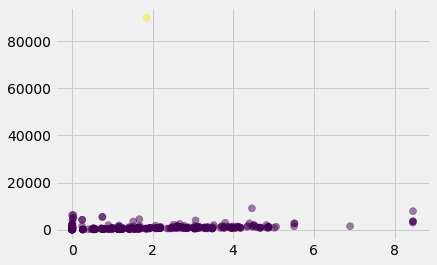

In [35]:
plt.scatter(X['distance'], X['trip_duration'], c=model.labels_, s=50, cmap='viridis', alpha=0.5)

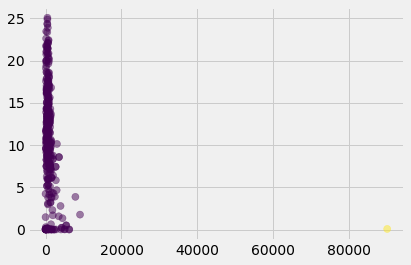

In [36]:
plt.scatter(X['trip_duration'], X['speed'], c=model.labels_, s=50, cmap='viridis', alpha=0.5)

Same conclusion as in k-means: an outlier is detected in one cluster.